In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os
from PIL import Image 
import PIL 
from IPython.display import clear_output
  
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [94]:
#!pip install -q git+https://github.com/tensorflow/examples.git

You should consider upgrading via the 'c:\users\aishu\miniconda\python.exe -m pip install --upgrade pip' command.


In [95]:
from tensorflow_examples.models.pix2pix import pix2pix

In [6]:
filenames = []
for file in os.listdir('WSISEG-Database-master/whole sky images/'):
    filenames.append(file)

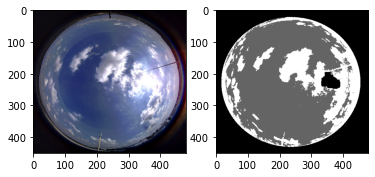

In [83]:
i = 0
for image in os.listdir('WSISEG-Database-master/whole sky images/'):
    #print(image.split('.')[0])
    #df[df['time_stamp']=='0101_0101075000'][['Azimuth Angle [degrees]','zenith','Total Cloud Cover [%]' ]]
    plt.subplot(121)
    im = plt.imread('WSISEG-Database-master/whole sky images/'+image)
    plt.imshow(im)
    plt.subplot(122)
    im = plt.imread('WSISEG-Database-master/annotation/'+image)
    plt.imshow(im,'gray')
    break

In [62]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.where(tf.equal(input_mask, 100), tf.ones_like(input_mask), input_mask)
    
    input_mask = tf.where(tf.equal(input_mask, 255), tf.ones_like(input_mask)*2, input_mask)
    #np.place(input_mask, input_mask==100, 1)
    #np.place(input_mask, input_mask==255, 2)
    return input_image, input_mask

In [73]:
def load_image(filename):
    filename= str(filename)
    im = plt.imread('WSISEG-Database-master/whole sky images/'+filename)

    input_image = tf.image.resize(im, (128, 128),method='nearest')
    im = plt.imread('WSISEG-Database-master/annotation/'+filename)
    im = np.expand_dims(im,-1)
    input_mask = tf.image.resize(im, (128, 128),method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [84]:
X = []
Y = []
for file in filenames:
    im,mask = load_image(file)
    X.append(im)
    Y.append(mask)

In [85]:
dataset_ = tf.data.Dataset.from_tensor_slices((X, Y))

In [64]:
TRAIN_LENGTH =len(filenames)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [87]:
DATASET_SIZE = len(filenames)
train_size = int(0.75 * DATASET_SIZE)
val_size = int(0.25 * DATASET_SIZE)



full_dataset = dataset_.shuffle(DATASET_SIZE )
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)
#val_dataset = temp_dataset.take(val_size)

batch_size=64   #TRY 128

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
train_dataset

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)>

In [89]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

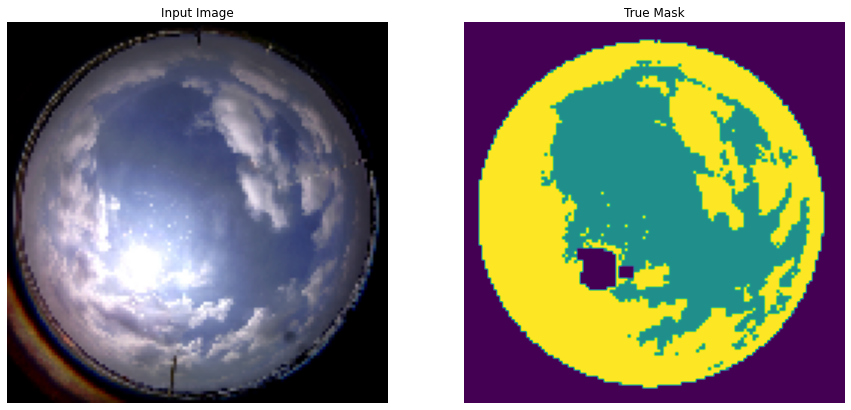

In [90]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [131]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [132]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [133]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [134]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

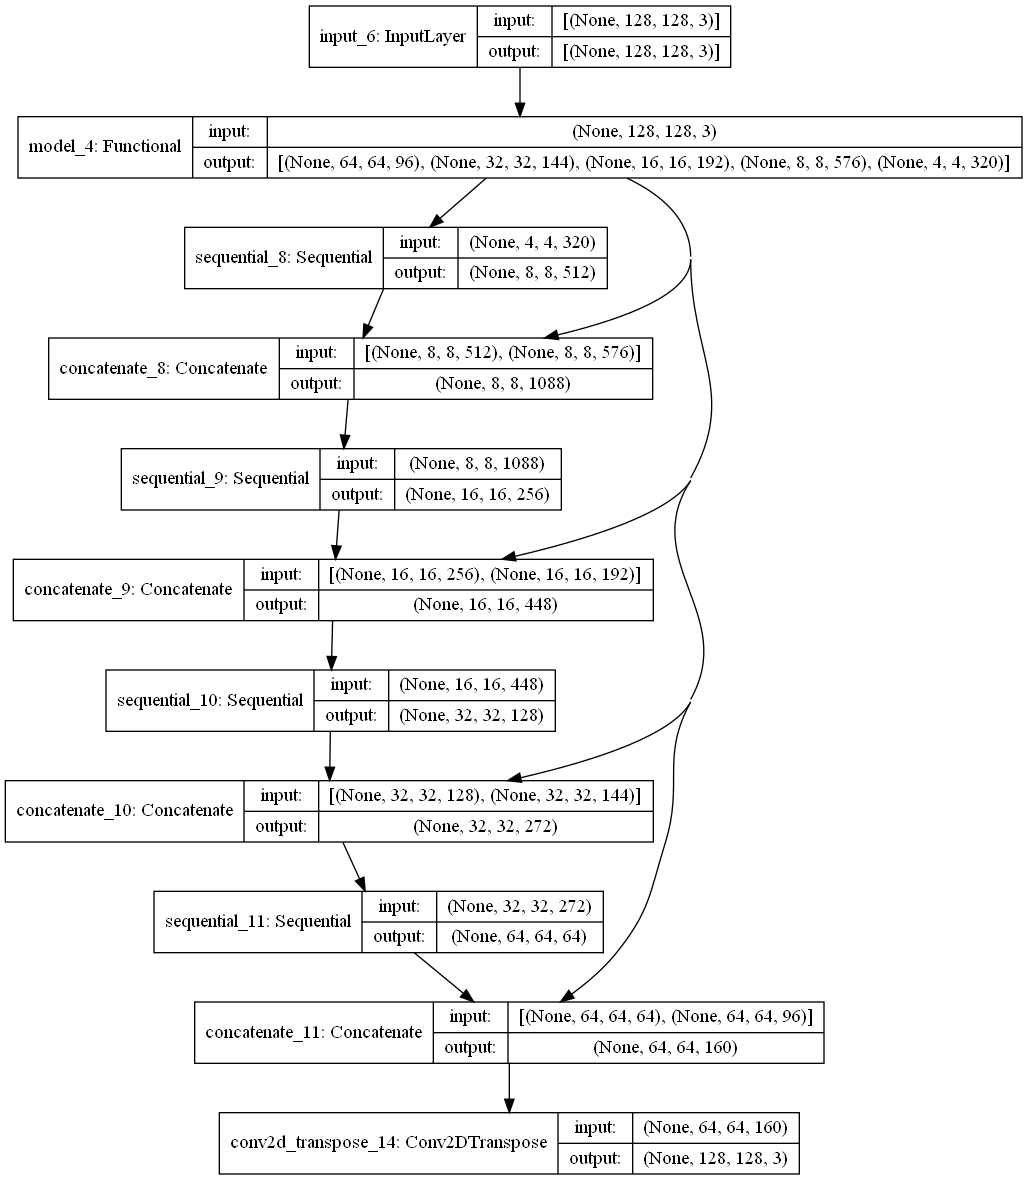

In [123]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [100]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [148]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
            
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

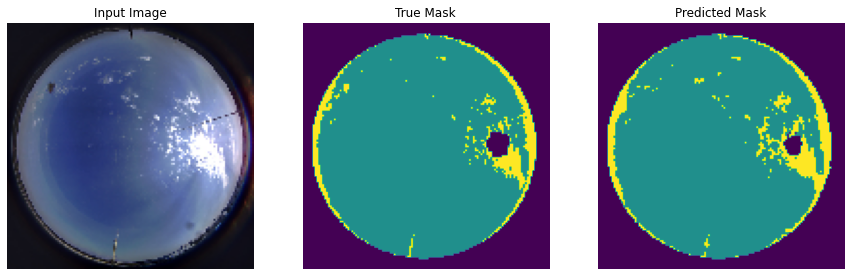

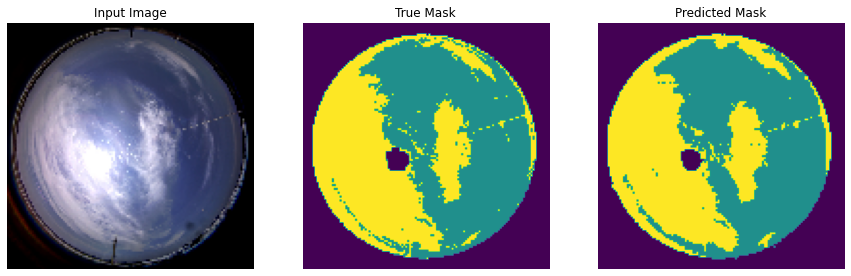

In [149]:
show_predictions(val_dataset, 4)

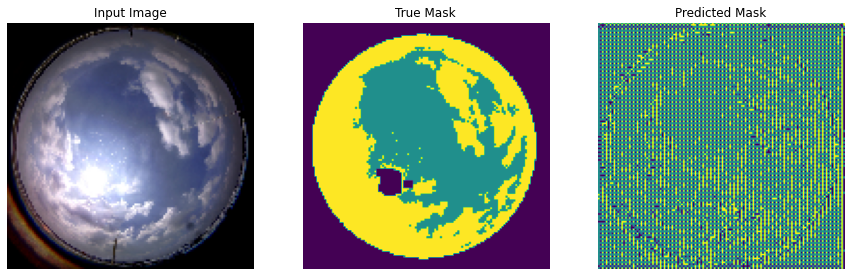

In [102]:
show_predictions()

In [105]:
checkpoint_filepath = './checkpoints3/my_checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [104]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

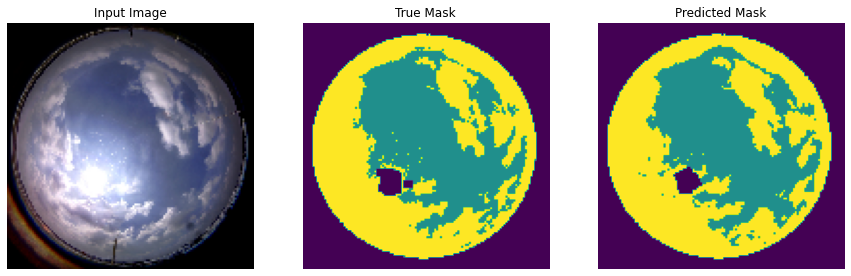


Sample Prediction after epoch 40



In [135]:
EPOCHS = 40
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = 100//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback()])

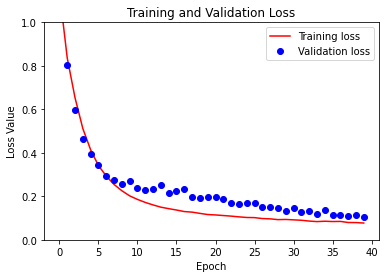

In [136]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

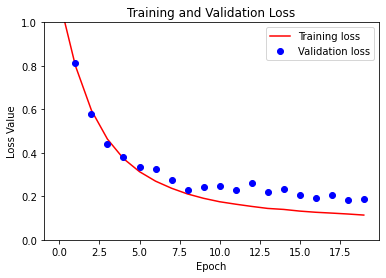

In [125]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

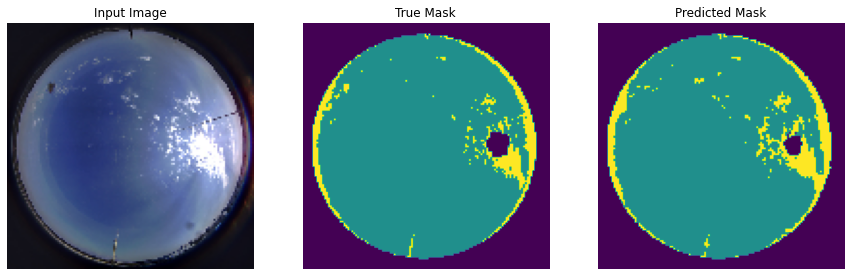

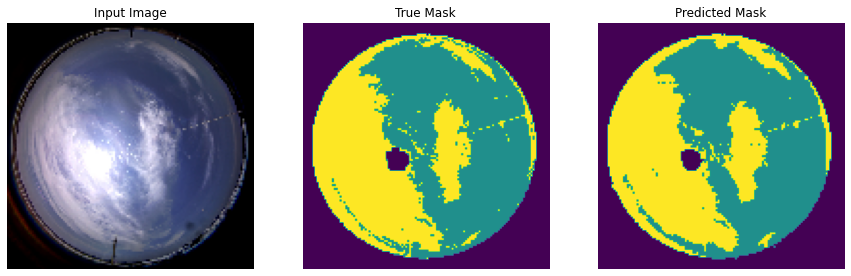

In [137]:
show_predictions(val_dataset, 3)

[-8.160024  -7.9697313 -7.933705  ... 10.006494  10.189409  10.361655 ]
[0 1 2]


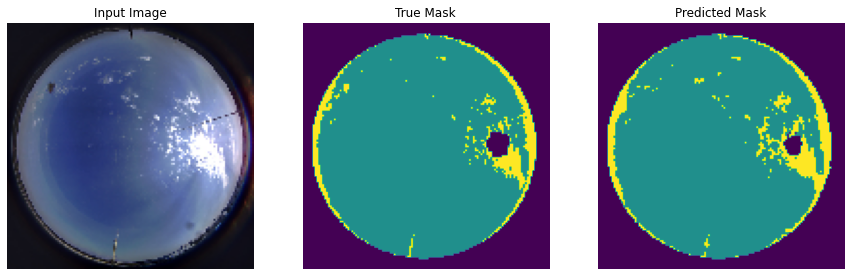

[0 1 2]
[-8.2197485 -8.178061  -8.118778  ...  9.521487   9.685879  10.122261 ]
[0 1 2]


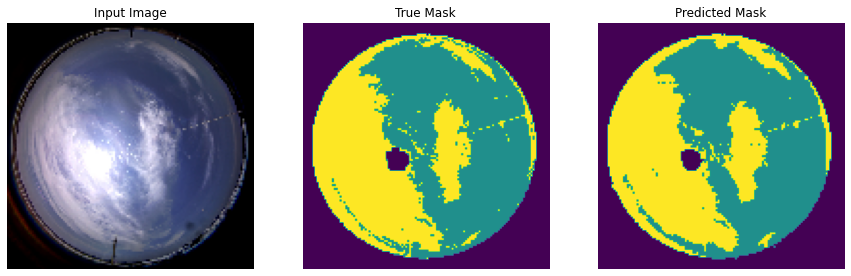

[0 1 2]


In [147]:
show_predictions(val_dataset, 4)

In [138]:
!mkdir -p saved_model
model.save('saved_model/cloud_seg')

INFO:tensorflow:Assets written to: saved_model/cloud_seg\assets


INFO:tensorflow:Assets written to: saved_model/cloud_seg\assets
c:\users\aishu\miniconda\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [139]:
new_model = tf.keras.models.load_model('saved_model/cloud_seg')

# Check its architecture
new_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            [(None, 64, 64, 96), 1841984     input_8[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model_6[0][4]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 8, 8, 1088)   0           sequential_12[0][0]              
                                                                 model_6[0][3]              

In [140]:
loss, acc = new_model.evaluate(val_dataset, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

2/2 - 3s - loss: 0.1030 - accuracy: 0.9677
Restored model, accuracy: 96.77%


#### Reference
1. https://amt.copernicus.org/preprints/amt-2019-356/amt-2019-356.pdf
2. Dataset: https://github.com/CV-Application/WSISEG-Database
3. https://www.tensorflow.org/tutorials/images/segmentation#what_is_image_segmentation